<a href="https://colab.research.google.com/github/Harsha2001-creater/603/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing PySpark**

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=85988acde69696fd8080db54e154a02576026074a2528e83be5e6e5e60529751
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Importing Necessary Libraries**

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from PIL import Image
import os
import random

In [3]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, input_file_name, lit, concat_ws
from pyspark.sql.types import StringType

# **Starting Spark session**

In [4]:
# Initialize SparkSession with increased memory
spark = SparkSession.builder.master("local[*]").appName("Dog Breed Prediction").config("spark.driver.memory", "16g").getOrCreate()


# **Mounting To Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Connecting to Data**

In [6]:
# Define directory path
main_images_directory = '/content/drive/MyDrive/images/'

In [7]:
# Function to recursively traverse the directory structure and collect file paths
def get_file_paths(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

# Get file paths
file_paths = get_file_paths(main_images_directory)

print(len(file_paths))

20580


In [8]:
import os

# Define the path to your annotations folder
annotations_folder = '/content/drive/MyDrive/Annotation'

# Dictionary to store file types and their counts
file_types = {}

# Function to get file extension
def get_file_extension(file_name):
    return os.path.splitext(file_name)[1]

# List all files in the annotations folder and its subfolders
for root, dirs, files in os.walk(annotations_folder):
    for file in files:
        file_type = get_file_extension(file)
        if file_type in file_types:
            file_types[file_type] += 1
        else:
            file_types[file_type] = 1

# Print the file types and their counts
print("File types found:")
for file_type, count in file_types.items():
    print(f"{file_type}: {count}")


File types found:
: 20580


# **Creating CSV file to store data like lables and paths**

In [ ]:
import os
import csv

# Define the path to the main images directory
main_images_directory = '/content/drive/MyDrive/images'  # Replace this with your main images directory
output_csv_file = '/content/drive/MyDrive/image_breed_mapping.csv'  # Replace this with the desired output CSV file path

# Open CSV file for writing
with open(output_csv_file, 'w', newline='') as csvfile:
    fieldnames = ['image_id', 'breed_name']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate through subfolders (each representing a breed)
    for breed_folder in os.listdir(main_images_directory):
        breed_path = os.path.join(main_images_directory, breed_folder)
        if os.path.isdir(breed_path):
            # Get breed name from subfolder name
            breed_name = breed_folder.split('-')[-1]
            # Iterate through image files in the breed folder
            for image_file in os.listdir(breed_path):
                # Get image ID from image filename
                image_id = os.path.splitext(image_file)[0]
                # Write image ID and breed name to CSV file
                writer.writerow({'image_id': image_id, 'breed_name': breed_name})

print("CSV file created successfully!")


CSV file created successfully!


In [9]:
import csv

# Define the path to the CSV file
csv_file = '/content/drive/MyDrive/image_breed_mapping.csv'  # Replace this with the path to your CSV file

# Open the CSV file for reading
with open(csv_file, 'r', newline='') as csvfile:
    # Create a CSV reader object
    reader = csv.DictReader(csvfile)

    # Print the header
    print("Image ID\tBreed Name")

    # Print the first few rows (head)
    for i, row in enumerate(reader):
        if i < 5:  # Print only the first 5 rows
            print(f"{row['image_id']}\t{row['breed_name']}")


Image ID	Breed Name
n02113712_1395	miniature_poodle
n02113712_1546	miniature_poodle
n02113712_1252	miniature_poodle
n02113712_1554	miniature_poodle
n02113712_1572	miniature_poodle


In [10]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("ImageBreedMapping") \
    .getOrCreate()

In [11]:
csv_file_path = "/content/drive/MyDrive/image_breed_mapping.csv"

# **Converting CSV to Data Frame**

In [12]:
image_breed_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [13]:
# Show the schema and first few rows of the DataFrame
image_breed_df.printSchema()
image_breed_df.show(5)

root
 |-- image_id: string (nullable = true)
 |-- breed_name: string (nullable = true)

+--------------+----------------+
|      image_id|      breed_name|
+--------------+----------------+
|n02113712_1395|miniature_poodle|
|n02113712_1546|miniature_poodle|
|n02113712_1252|miniature_poodle|
|n02113712_1554|miniature_poodle|
|n02113712_1572|miniature_poodle|
+--------------+----------------+
only showing top 5 rows



In [14]:
from pyspark.sql.functions import concat_ws, col, split

# Split the image_id column at '_' and select the first part
image_id_prefix = split(col("image_id"), "_").getItem(0)

# Concatenate the first part of image_id with breed_name using '-' in between
image_breed_df = image_breed_df.withColumn("image_filename", concat_ws("-", image_id_prefix, col("breed_name")))

# Show the updated DataFrame with image filenames
image_breed_df.show(5)


+--------------+----------------+--------------------+
|      image_id|      breed_name|      image_filename|
+--------------+----------------+--------------------+
|n02113712_1395|miniature_poodle|n02113712-miniatu...|
|n02113712_1546|miniature_poodle|n02113712-miniatu...|
|n02113712_1252|miniature_poodle|n02113712-miniatu...|
|n02113712_1554|miniature_poodle|n02113712-miniatu...|
|n02113712_1572|miniature_poodle|n02113712-miniatu...|
+--------------+----------------+--------------------+
only showing top 5 rows



# **EAD (Exploratory Data Anlysis)**

In [15]:
from pyspark.sql.functions import concat, lit

# image_breed_df.show()
# Construct the image path using the concat function
main_images_directory = '/content/drive/MyDrive/images'
from pyspark.sql.functions import concat, lit

# Construct the image path using the concat function
image_breed_df = image_breed_df.withColumn("image_path", concat(lit(main_images_directory), lit("/"), col("image_filename"), lit("/"), col("image_id"), lit(".jpg")))

# Show the updated DataFrame with image paths
image_breed_df.show(5)

# Show the updated DataFrame with image paths
# image_breed_df.show(5)


+--------------+----------------+--------------------+--------------------+
|      image_id|      breed_name|      image_filename|          image_path|
+--------------+----------------+--------------------+--------------------+
|n02113712_1395|miniature_poodle|n02113712-miniatu...|/content/drive/My...|
|n02113712_1546|miniature_poodle|n02113712-miniatu...|/content/drive/My...|
|n02113712_1252|miniature_poodle|n02113712-miniatu...|/content/drive/My...|
|n02113712_1554|miniature_poodle|n02113712-miniatu...|/content/drive/My...|
|n02113712_1572|miniature_poodle|n02113712-miniatu...|/content/drive/My...|
+--------------+----------------+--------------------+--------------------+
only showing top 5 rows



In [16]:
print(image_breed_df.select('image_path').show(truncate=False))

+----------------------------------------------------------------------------+
|image_path                                                                  |
+----------------------------------------------------------------------------+
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1395.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1546.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1252.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1554.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1572.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1331.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1541.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1036.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_poodle/n02113712_1302.jpg |
|/content/drive/MyDrive/images/n02113712-miniature_p

In [17]:
# Get the number of rows
num_rows = image_breed_df.count()

# Get the number of columns
num_cols = len(image_breed_df.columns)

# Print the shape
print("Shape of image_breed_df: ({}, {})".format(num_rows, num_cols))


Shape of image_breed_df: (20580, 4)


## **Displaying images**

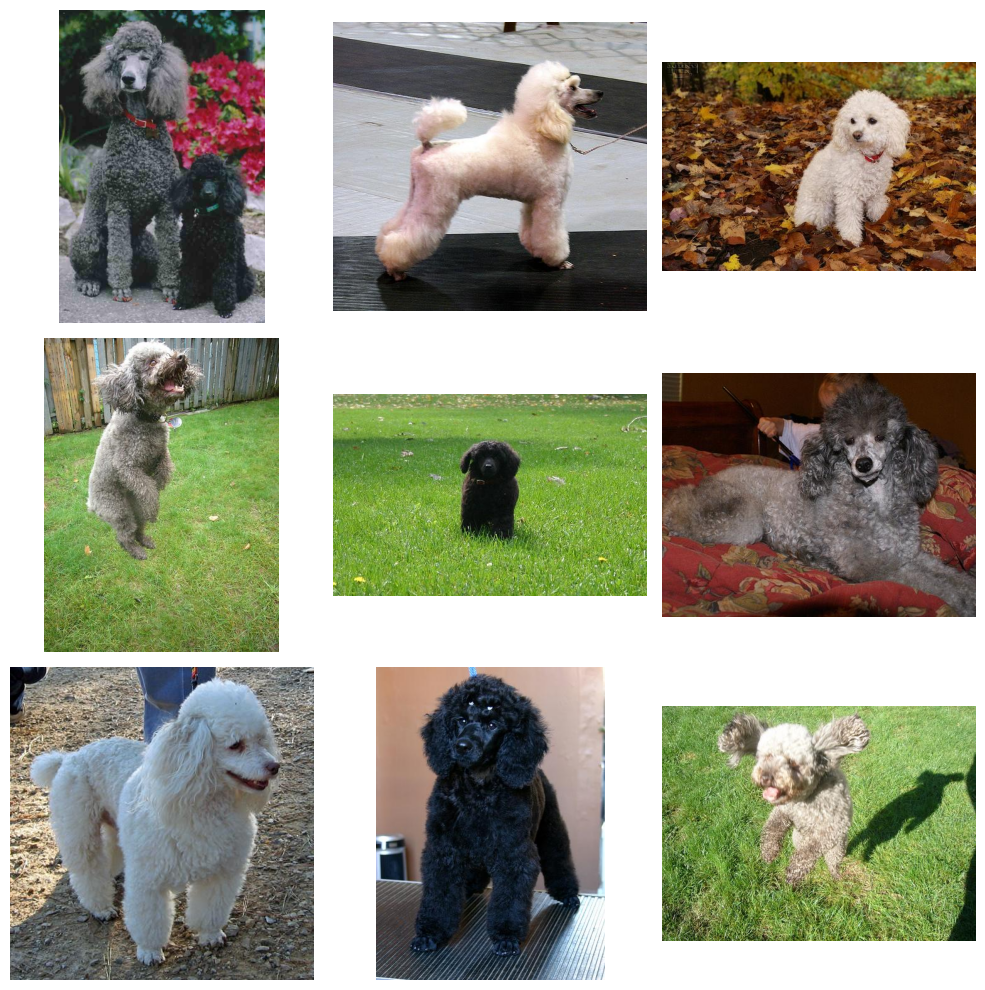

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Sample 9 image paths from 'image_breed_df'
sampled_images = image_breed_df.select("image_path").sample(False, 0.1).limit(9)
# Collect the sampled image paths to the driver node
sampled_images_list = [row.image_path for row in sampled_images.collect()]

# Display images using Matplotlib
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, image_path in enumerate(sampled_images_list):
    try:
        # Read the image from the local file system
        with open(image_path, 'rb') as f:
            img = plt.imread(f)
        # Plot the image
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
    except Exception as e:
        print(f"Error opening image '{image_path}': {e}")

plt.tight_layout()
plt.show()


In [19]:
# Group by 'breed_name' and count occurrences
value_counts = image_breed_df.groupBy('breed_name').count().orderBy('breed_name')

# Show the counts
value_counts.show()


+--------------------+-----+
|          breed_name|count|
+--------------------+-----+
|        Afghan_hound|  239|
| African_hunting_dog|  169|
|            Airedale|  202|
|American_Stafford...|  164|
|         Appenzeller|  151|
|  Australian_terrier|  196|
|  Bedlington_terrier|  182|
|Bernese_mountain_dog|  218|
|    Blenheim_spaniel|  188|
|       Border_collie|  150|
|      Border_terrier|  172|
|         Boston_bull|  182|
|Bouvier_des_Flandres|  150|
|   Brabancon_griffon|  153|
|    Brittany_spaniel|  152|
|            Cardigan|  155|
|Chesapeake_Bay_re...|  167|
|           Chihuahua|  152|
|      Dandie_Dinmont|  180|
|            Doberman|  150|
+--------------------+-----+
only showing top 20 rows



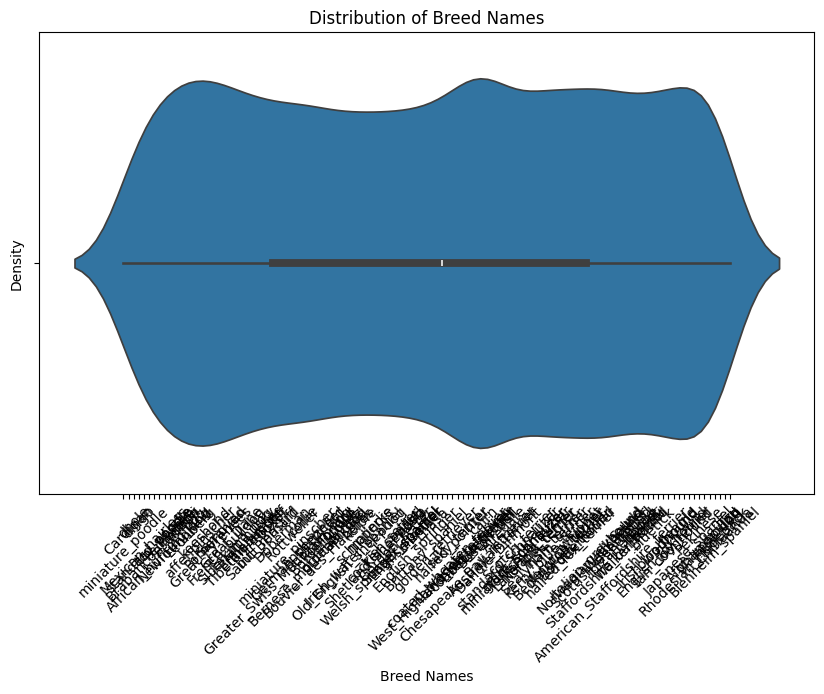

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
data_pd = image_breed_df.toPandas()

# Create violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='breed_name', data=data_pd)
plt.title('Distribution of Breed Names')
plt.xlabel('Breed Names')
plt.ylabel('Density')
plt.xticks()  # Rotate x-axis labels for better visibility
plt.show()


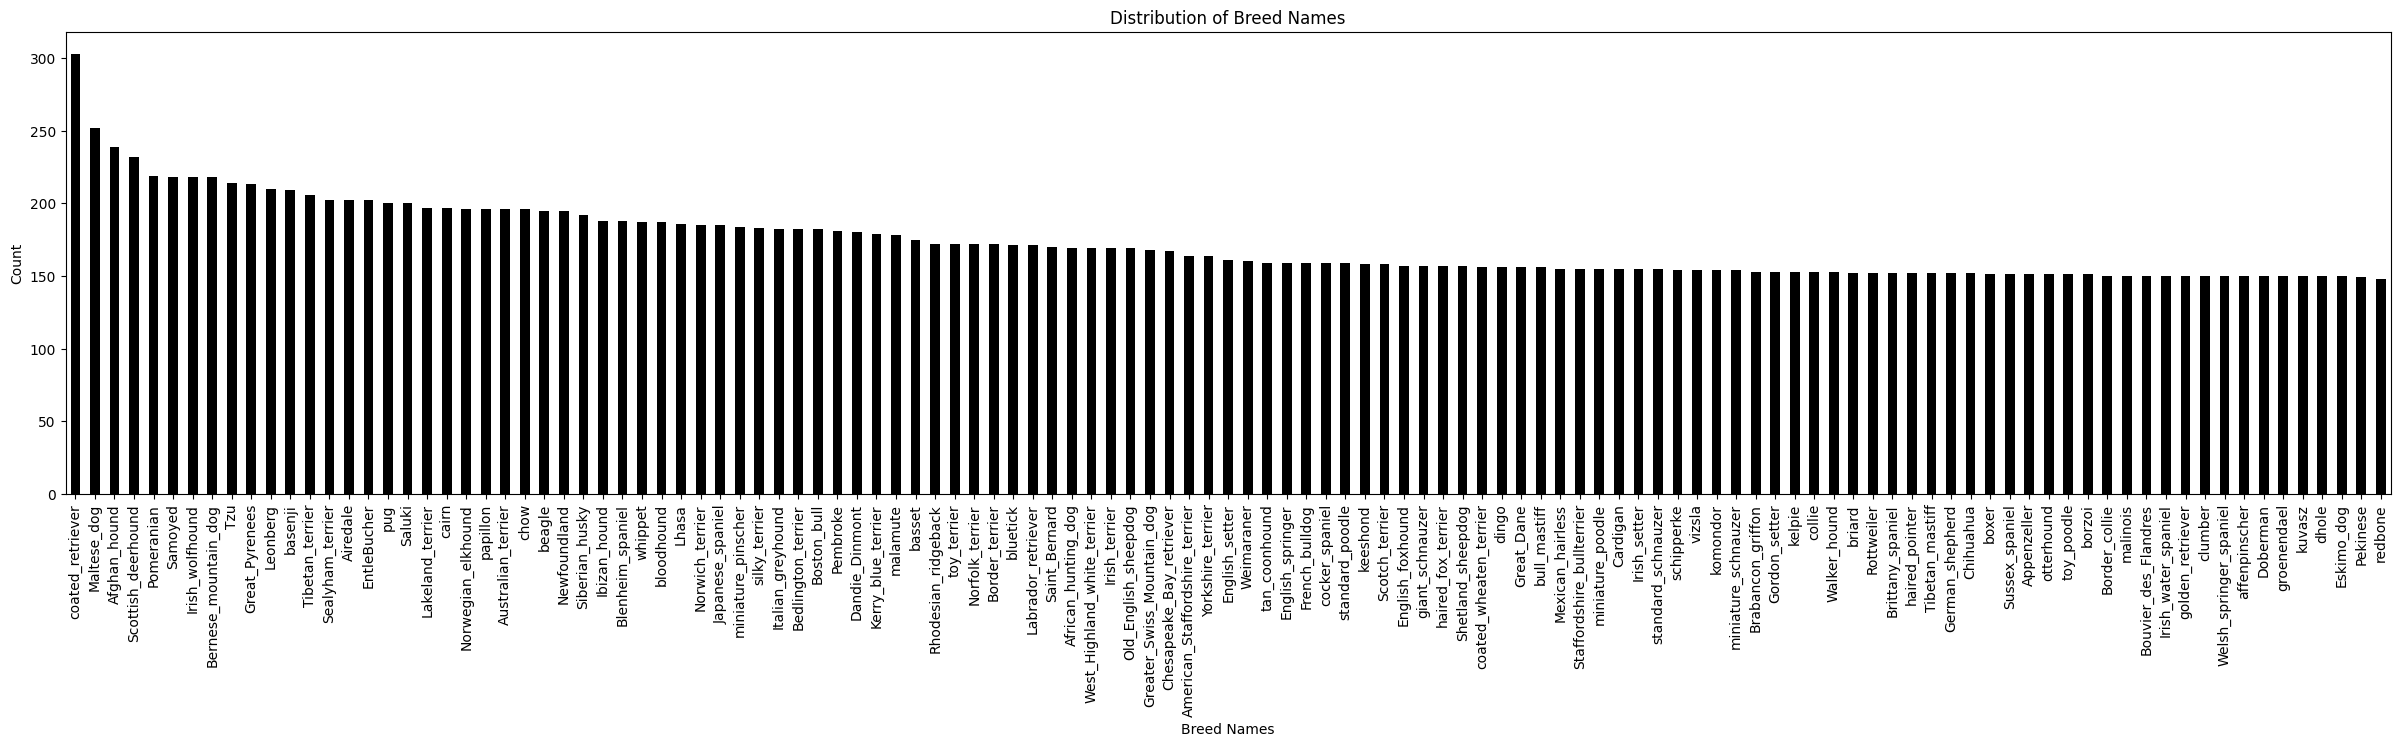

In [23]:

# Create bar plot
plt.figure(figsize=(30, 6))
data_pd['breed_name'].value_counts().plot(kind='bar', color='black')
plt.title('Distribution of Breed Names')
plt.xlabel('Breed Names')
plt.ylabel('Count')
plt.xticks()  # Rotate x-axis labels for better visibility
plt.show()


In [24]:
import numpy as np
import cv2
from pyspark.sql.functions import col, udf
from pyspark.sql.types import BinaryType

# Define a function to resize the image
def resize_image(image):
    try:
        # Read the image as numpy array
        img = cv2.imread(image)
        # Check if the image is empty or invalid
        if img is None or img.size == 0:
            return None
        # Resize the image
        resized_img = cv2.resize(img, (224, 224))  # Adjust the size as needed
        # Convert the resized image back to binary format
        return cv2.imencode('.jpg', resized_img)[1].tobytes()
    except Exception as e:
        print(f"Error resizing image: {e}")
        return None

# Define a UDF to apply the resizing function
resize_udf = udf(resize_image, BinaryType())

# Apply the UDF to resize the images
resized_df = image_breed_df.withColumn("resized_image", resize_udf(col("image_path")))

# Filter out rows with empty or invalid images
resized_df = resized_df.filter(col("resized_image").isNotNull())

# Display the resulting DataFrame
resized_df.show()


+---------------+----------------+--------------------+--------------------+--------------------+
|       image_id|      breed_name|      image_filename|          image_path|       resized_image|
+---------------+----------------+--------------------+--------------------+--------------------+
| n02113712_1395|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1546|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1252|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1554|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1572|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1331|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1541|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|
| n02113712_1036|min

# **Defining Height and Width**

In [26]:
from pyspark.sql.types import StructType, StructField, IntegerType

# Function to calculate height and width of images
def calculate_height_width(image_bytes):
    try:
        # Convert image bytes to numpy array
        img_np = np.frombuffer(image_bytes, dtype=np.uint8)
        # Decode image array
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        # Get image shape (height, width)
        height, width, _ = img.shape
        return height, width
    except Exception as e:
        print(f"Error occurred while calculating height and width: {e}")
        return None, None

# Define the schema for the return type
schema = StructType([
    StructField("height", IntegerType()),
    StructField("width", IntegerType())
])

# Define a UDF to apply the function to calculate height and width
height_width_udf = udf(calculate_height_width, schema)

# Apply the UDF to calculate height and width
resized_df = resized_df.withColumn("height_width", height_width_udf(col("resized_image")))

# Now you can access the height and width using the "height_width" column


In [27]:
resized_df.show()

+---------------+----------------+--------------------+--------------------+--------------------+------------+
|       image_id|      breed_name|      image_filename|          image_path|       resized_image|height_width|
+---------------+----------------+--------------------+--------------------+--------------------+------------+
| n02113712_1395|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
| n02113712_1546|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
| n02113712_1252|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
| n02113712_1554|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
| n02113712_1572|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
| n02113712_1331|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|  {224, 224}|
|

In [29]:
# Extract height and width into separate columns
resized_df = resized_df.withColumn("height", col("height_width.height")).withColumn("width", col("height_width.width")).drop("height_width")

In [33]:
resized_df.show(5)

+--------------+----------------+--------------------+--------------------+--------------------+------+-----+
|      image_id|      breed_name|      image_filename|          image_path|       resized_image|height|width|
+--------------+----------------+--------------------+--------------------+--------------------+------+-----+
|n02113712_1395|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|
|n02113712_1546|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|
|n02113712_1252|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|
|n02113712_1554|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|
|n02113712_1572|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|
+--------------+----------------+--------------------+--------------------+--------------------+------+-----+
only showi

# **Grey Scaling Images**

In [35]:
import cv2
from pyspark.sql.functions import udf
from pyspark.sql.types import BinaryType

# Define a function to convert images to grayscale
def convert_to_grayscale(image_bytes):
    try:
        # Convert image bytes to numpy array
        img_np = np.frombuffer(image_bytes, dtype=np.uint8)
        # Decode image array
        img = cv2.imdecode(img_np, cv2.IMREAD_COLOR)
        # Convert image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Encode the grayscale image back to binary format
        return cv2.imencode('.jpg', gray_img)[1].tobytes()
    except Exception as e:
        print(f"Error converting image to grayscale: {e}")
        return None

# Define a UDF to apply the grayscale conversion function
grayscale_udf = udf(convert_to_grayscale, BinaryType())

# Apply the UDF to create a new column with grayscale images
grayscale_df = resized_df.withColumn("grayscale_image", grayscale_udf(col("resized_image")))


# **Checking if grey scale is done**

In [37]:
# Check the data type of the grayscale_image column
print("Data type of grayscale_image column:", grayscale_df.schema["grayscale_image"].dataType)


Data type of grayscale_image column: BinaryType()


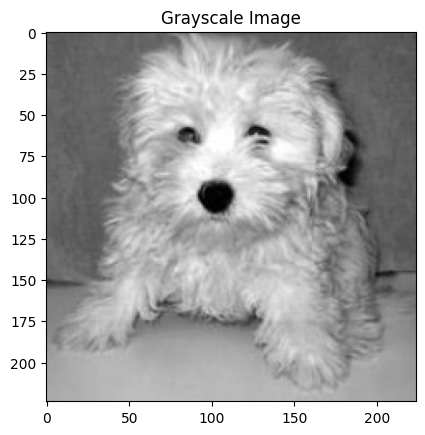

Original Image Size: 224x224
Grayscale Image Size: 224x224
Pixel Values:
[[ 93  92  90 ...  93  86  82]
 [ 96  96  95 ...  95  86  83]
 [ 94  95  95 ...  88  77  76]
 ...
 [171 171 171 ... 158 159 160]
 [171 171 171 ... 159 159 159]
 [171 171 171 ... 160 159 159]]


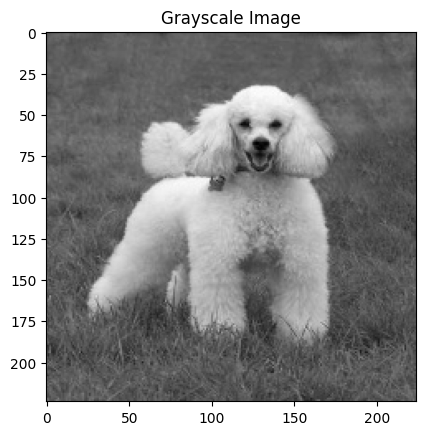

Original Image Size: 224x224
Grayscale Image Size: 224x224
Pixel Values:
[[ 83  88  91 ... 101 105  95]
 [ 90  92  94 ... 100 105  99]
 [ 94  95  99 ... 101 106 105]
 ...
 [ 82  86  82 ... 111 100  94]
 [116 107  91 ... 105 111  97]
 [106 117  92 ...  97 123  96]]


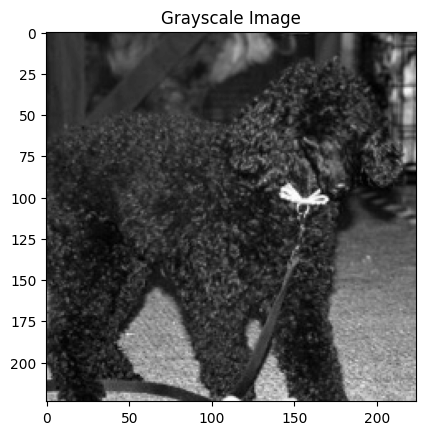

Original Image Size: 224x224
Grayscale Image Size: 224x224
Pixel Values:
[[ 31  38  42 ...  45  58  73]
 [ 31  38  42 ...  42  48  58]
 [ 30  38  43 ...  60  58  62]
 ...
 [168 167 161 ... 208 178 170]
 [161 169 146 ... 180 181 190]
 [160 198 167 ... 175 169 171]]


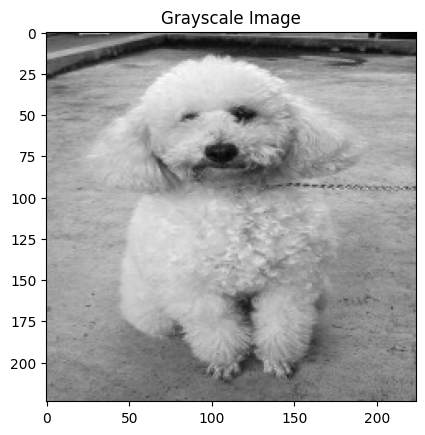

Original Image Size: 224x224
Grayscale Image Size: 224x224
Pixel Values:
[[ 62  64  59 ...  10  11  12]
 [ 59  66  66 ...  12  11  10]
 [ 55  56  47 ...  12  12  11]
 ...
 [108 114 107 ... 106 100 107]
 [123 121 111 ... 101  95 104]
 [128 124 116 ...  95  84  97]]


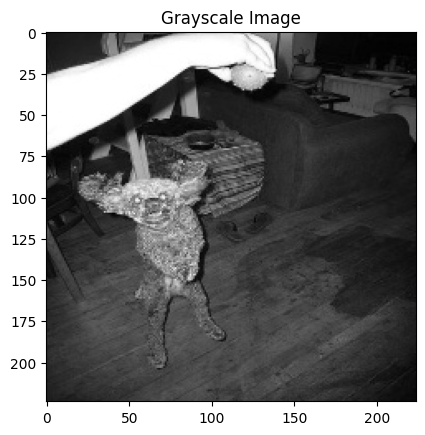

Original Image Size: 224x224
Grayscale Image Size: 224x224
Pixel Values:
[[18 19 21 ...  4  4  4]
 [20 21 22 ...  4  4  4]
 [22 22 23 ...  4  4  4]
 ...
 [31 31 32 ... 10  9  9]
 [29 31 31 ... 11 10 10]
 [28 30 30 ...  9  8  9]]


In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from PIL import Image

# Function to convert binary image data to numpy array
def bytes_to_numpy(image_bytes):
    try:
        # Decode image bytes
        img_np = np.frombuffer(image_bytes, dtype=np.uint8)
        # Reshape array to image dimensions
        img = cv2.imdecode(img_np, cv2.IMREAD_GRAYSCALE)
        return img
    except Exception as e:
        print(f"Error converting image bytes to numpy array: {e}")
        return None

# Sample some rows from the DataFrame
sample_df = grayscale_df.sample(False, 0.1).limit(5)

# Convert binary image data to numpy array and display
for row in sample_df.collect():
    img_np = bytes_to_numpy(row["grayscale_image"])
    if img_np is not None:
        # Visual inspection: Display the grayscale image
        plt.imshow(img_np, cmap='gray')
        plt.title("Grayscale Image")
        plt.show()

        # Check image size: Verify that dimensions of grayscale images are the same as the original images
        original_width, original_height = row["width"], row["height"]
        grayscale_width, grayscale_height = img_np.shape[1], img_np.shape[0]
        print(f"Original Image Size: {original_width}x{original_height}")
        print(f"Grayscale Image Size: {grayscale_width}x{grayscale_height}")

        # Check pixel values: Inspect pixel values of grayscale images
        print("Pixel Values:")
        print(img_np)


By observing the results we can see that images have been greyscaled sucessfully

In [39]:
grayscale_df.show()

+---------------+----------------+--------------------+--------------------+--------------------+------+-----+--------------------+
|       image_id|      breed_name|      image_filename|          image_path|       resized_image|height|width|     grayscale_image|
+---------------+----------------+--------------------+--------------------+--------------------+------+-----+--------------------+
| n02113712_1395|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|[FF D8 FF E0 00 1...|
| n02113712_1546|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|[FF D8 FF E0 00 1...|
| n02113712_1252|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|[FF D8 FF E0 00 1...|
| n02113712_1554|miniature_poodle|n02113712-miniatu...|/content/drive/My...|[FF D8 FF E0 00 1...|   224|  224|[FF D8 FF E0 00 1...|
| n02113712_1572|miniature_poodle|n02113712-miniatu...|/content/drive/My...|

# **Train and Test Split**

In [41]:
# Split the dataset into training and test sets (80% training, 20% test)
train_df, test_df = resized_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
train_df.show()